# Calibration of groundwater models

Based on researches from Jana Glass, see word document.  
Uses the given Head-Observation-File `./calibration.hob_out`

In [1]:
import numpy as np

### Read the head-observation output file

Let's create temporarily lists for simulated and observed values

In [2]:
f = open('./calibration.hob_out', 'r')

header = False

names = [] 
observed = [] 
simulated = []

for line in f:
    if line.startswith('#'):
        continue
    
    if header == False:
        header = line.split('"')[1::2]
        continue
        
    values = line.split()
    simulated.append(float(values[0]))
    observed.append(float(values[1]))
    names.append('_'.join(values[2].split('_')[:-1]))
    
    
simulated = np.array(simulated)
observed = np.array(observed)

## Calculate statistics

### Number of data points n


In [3]:
n = len(simulated)
print (n)

288


### Maximum residual (rMax)

In [4]:
rMax = np.max(np.abs(simulated-observed))
print(rMax)

3.4412841796


### Minimum residual (rMin)

In [5]:
rMin = np.min(np.abs(simulated-observed))
print(rMin)

0.006655216219999982


### Residual mean (rMean)

In [6]:
rMean = np.mean(simulated-observed)
print(rMean)

-0.37619232149534787


### Absolute residual mean (arMean)

In [7]:
arMean = np.mean(abs(simulated-observed))
print(arMean)

1.0508644575506798


### Standard error of the estimate SSE

In [8]:
from scipy import stats

sse = stats.sem(simulated-observed)
print(sse)

0.07416341705564417


### Root Mean Sqared Error RMSE

In [9]:
rmse = np.sqrt(((simulated-observed) ** 2).mean())
print(rmse)

1.3115188256296897


### Normalized Root Mean Sqared Error RMSE

In [10]:
nrmse = rmse / (np.max(observed) - np.min(observed))
print(nrmse)

0.048164481260051156


### Correlation Coefficient R (Pearson)

In [11]:
R = stats.pearsonr(observed, simulated)[0]
print(R)

0.9925449039129356


### Coefficient of Determination R2

In [12]:
from sklearn.metrics import r2_score

print(r2_score(observed, simulated))

0.9694114022467805


## Plot simulated vs. observed values

__Done__

* Plot simulated on y-axis, observed heads on x-axis
* Automatic scale for x- and y-axis
* Plot every well with different color
* Include Line of equality (1:1)


__Todo__

* Include in plot: off/on for different wells

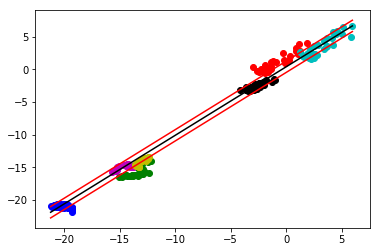

In [13]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

current_name = names[0]
last_index = 0

for index, name in enumerate(names):
    if current_name == name:
        continue
    
    plt.scatter(
        observed[last_index:index], 
        simulated[last_index:index],
        color=next(colors)
    )
    
    last_index = index
    current_name = name
    
plt.plot(
    [np.min(observed), np.max(observed)], 
    [np.min(simulated), np.max(simulated)],
    'k-'
)

Z = 1.96
std = np.std(observed)
delta = Z * std / np.sqrt(n)

plt.plot(
    [np.min(observed), np.max(observed)], 
    [np.min(simulated)-delta, np.max(simulated)-delta],
    'r-'
)

plt.plot(
    [np.min(observed), np.max(observed)], 
    [np.min(simulated)+delta, np.max(simulated)+delta],
    'r-'
)

plt.show()

## Plot (weighted) residuals vs. simulated heads

* Weighted residuals vs. simulated heads
* Linear regression line with equation
* Bold marked 0-line 

Weighted residuals should be evenly distributed about zero for all weighted simulated values, and should display no trends with the weighted simulated values

Trends or unequal variances are indicators of model bias

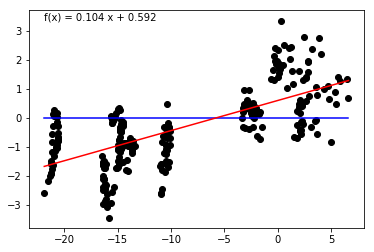

In [14]:
weightedResiduals = (simulated - observed)
linRegress = stats.linregress(simulated, weightedResiduals)

plt.scatter(
        simulated,
        weightedResiduals,
        color='k'
    )

xMin = np.min(simulated)
xMax = np.max(simulated)
yMin = xMin * linRegress.slope + linRegress.intercept
yMax = xMax * linRegress.slope + linRegress.intercept

plt.plot([xMin, xMax], [0, 0], 'b-')
plt.plot([xMin, xMax], [yMin, yMax],'r-')

text = "f(x) = {} x + {}".format(round(linRegress.slope,3), round(linRegress.intercept,3))
plt.text(xMin, np.max(weightedResiduals), text)

plt.show()

### Check for Normal Distribution

* Rank residuals
* Calculate Normal Probability Function
* Plot ranked residuals against NPF
* Calculate linear regression line and R<sup>2</sup>

__ -> residuals should plot on straight line -> normally distributed__

In [15]:
rankedResiduals = np.sort(simulated - observed)

xMin = rankedResiduals[0]
xMax = rankedResiduals[-1]

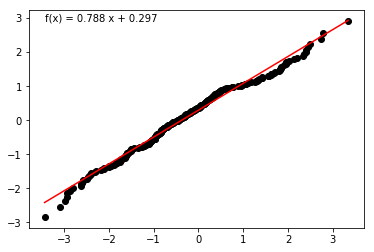

In [16]:
def calculateNpf(x, n):
    a = 0.5
    if x < 11:
        a = 3/8
        
    return stats.norm.ppf((x-a)/(288+1-2*a))

xMin = np.min(rankedResiduals)
xMax = np.max(rankedResiduals)
    
NPF = np.linspace(1, n, num=n)
NPF = list(map(lambda x, n: calculateNpf(x, n), NPF, np.ones(n)*n))

plt.scatter(rankedResiduals, NPF, c='k')

linRegress = stats.linregress(rankedResiduals, NPF)

plt.plot(
    [xMin, xMax],
    [
        xMin * linRegress.slope + linRegress.intercept, 
        xMax * linRegress.slope + linRegress.intercept
    ],
    'r-'
)

text = "f(x) = {} x + {}".format(round(linRegress.slope,3), round(linRegress.intercept,3))
plt.text(xMin, np.max(NPF), text)

plt.show()